In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-bert

In [ ]:
import os
os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert

In [ ]:
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
    print('We will use the GPU:', device_name)
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0
We will use the GPU: /device:GPU:0


In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_file.txt', sep='{}{}{}', engine = 'python')
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_file.txt", sep= '{}{}{}', engine = 'python')

#from sklearn.model_selection import train_test_split

train, val =  train,test

In [ ]:
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip

File ‘cased_L-12_H-768_A-12.zip’ already there; not retrieving.



In [ ]:
# Give -n argument so that existing files aren't overwritten 
!unzip -n cased_L-12_H-768_A-12.zip

Archive:  cased_L-12_H-768_A-12.zip


In [ ]:
bert_vocab_path = 'cased_L-12_H-768_A-12/vocab.txt'
bert_config_path = 'cased_L-12_H-768_A-12/bert_config.json'
bert_checkpoint_path = 'cased_L-12_H-768_A-12/bert_model.ckpt'    # suffixes not required

In [ ]:
model_is_cased = True

In [ ]:
from sklearn.utils import shuffle

train = shuffle(train)
train.head()

,Label,Text
5592,__label__ne,Regional Police also maintained a strong road ...
8069,__label__pb,Two and a Half We just got back today from 5 ...
5001,__label__ne,iPhone update on the way A few days back we s...
5518,__label__ne,Canadian Forces Snowbirds to be Inaugural Head...
13648,__label__sr,"Paul Kent, Dean Ritchie and Paul Crawley discu..."


In [ ]:
vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters


# Print a list with every 500th vocabulary item
print(vocab[0::500])
print(len(vocab))

['[PAD]', 'щ', '吉', 'told', 'space', 'operations', 'proposed', 'Oxford', 'showing', 'domestic', 'mountains', 'commission', 'voices', 'associate', 'hills', 'Guide', 'relaxed', 'Page', 'Heights', 'singers', 'Interior', 'considers', 'facilitate', 'shouting', '1826', 'constitute', 'alter', 'clip', 'Into', 'Memory', 'ballad', 'Owens', 'Langdon', 'aquatic', 'stereo', 'Cass', 'Shock', '195', '##tec', '##sonic', 'attested', '##rdes', '1840s', '##90', 'Guys', '##rien', 'Munro', 'Ursula', 'mesh', 'diplomacy', 'Newmarket', '##oughs', 'synthesizers', 'Drugs', 'monstrous', '##ynamic', 'troll', '##ٹ']
28996


In [ ]:
from pprint import pprint    # pretty-printer for output
import json

with open(bert_config_path) as f:
    config = json.load(f)


# Print configuration contents
pprint(config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 28996}


In [ ]:
import random
# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }


# Print some random examples of the mapping
pprint(dict(random.choices(list(token_dict.items()), k=10)))

{'##FM': 17938,
 '##father': 16064,
 '##Ţ': 28247,
 '1874': 7079,
 'Azerbaijani': 19736,
 'Community': 3704,
 'Territories': 18057,
 'Volunteer': 12744,
 'centred': 17720,
 'corresponds': 15497}


In [ ]:
from keras_bert import Tokenizer


tokenizer = Tokenizer(token_dict, cased=model_is_cased)


# Let's test that out
for s in ['Hello BERT!', 'Unknown: unknown 你']:
    print('Original string:', s)
    print('Tokenized:', tokenizer.tokenize(s))
    indices, segments = tokenizer.encode(s, max_len=20)    # max_len for padding and truncation
    print('Encoded:', indices)
    print('Segments:', segments)
    print('Decoded:', ' '.join(tokenizer.decode(indices)))
    print()

Original string: Hello BERT!
Tokenized: ['[CLS]', 'Hello', 'B', '##ER', '##T', '!', '[SEP]']
Encoded: [101, 8667, 139, 9637, 1942, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Hello B ##ER ##T !

Original string: Unknown: unknown 你
Tokenized: ['[CLS]', 'Unknown', ':', 'unknown', '你', '[SEP]']
Encoded: [101, 16285, 131, 3655, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Unknown : unknown [UNK]



In [ ]:
#print(train['Text'].values[17587])
len(tokenizer.tokenize(train['Text'].values[17587]))

819

In [ ]:
train.head()
train['Label'].values

array(['__label__ne', '__label__pb', '__label__ne', ..., '__label__ne',
       '__label__qa', '__label__ib'], dtype=object)

In [ ]:
#Label encoding the label columns

label_encode = {}
for i, v  in enumerate(train['Label'].unique()):
  label_encode[v] = i
label_encode

{'__label__av': 18,
 '__label__df': 7,
 '__label__dp': 10,
 '__label__ds': 8,
 '__label__dt': 4,
 '__label__en': 11,
 '__label__fi': 21,
 '__label__fs': 24,
 '__label__ha': 17,
 '__label__ht': 6,
 '__label__ib': 5,
 '__label__it': 14,
 '__label__ne': 0,
 '__label__ob': 3,
 '__label__pb': 1,
 '__label__po': 23,
 '__label__qa': 9,
 '__label__ra': 22,
 '__label__re': 19,
 '__label__rs': 13,
 '__label__rv': 12,
 '__label__sl': 16,
 '__label__sr': 2,
 '__label__ss': 20,
 '__label__tb': 15,
 '__label__tv': 25}

In [ ]:
train['Label_enc'] = train['Label'].map(label_encode)
val['Label_enc'] = val['Label'].map(label_encode)
train.head()

,Label,Text,Label_enc
5592,__label__ne,Regional Police also maintained a strong road ...,0
8069,__label__pb,Two and a Half We just got back today from 5 ...,1
5001,__label__ne,iPhone update on the way A few days back we s...,0
5518,__label__ne,Canadian Forces Snowbirds to be Inaugural Head...,0
13648,__label__sr,"Paul Kent, Dean Ritchie and Paul Crawley discu...",2


In [ ]:
print("Training Set Shape :", train.shape)
print("Test Set Shape :", val.shape)

Training Set Shape : (17588, 3)
Test Set Shape : (2210, 3)


In [ ]:
#Get value counts of each classes

train['Label_enc'].value_counts()

0     5577
2     1711
3     1445
7     1268
1     1203
4     1108
12     802
9      638
6      586
8      482
16     369
11     326
13     323
22     294
5      236
18     222
10     213
14     193
17     145
20     129
15      90
19      89
21      76
23      38
24      16
25       9
Name: Label_enc, dtype: int64

In [ ]:
# Separate the dataset for the purpose of upsampling and downsampling based on threshold of 802

trainDown = train[train['Label_enc'].map(train['Label_enc'].value_counts()) >= 802]
trainUp = train[train['Label_enc'].map(train['Label_enc'].value_counts()) <= 802]
#trainUp['Label_enc'].value_counts()

In [ ]:
# Separate the dataset for the purpose of upsampling and downsampling based on threshold of 802

trainDown = train[train['Label_enc'].map(train['Label_enc'].value_counts()) >= 802]
trainUp = train[train['Label_enc'].map(train['Label_enc'].value_counts()) <= 802]
#trainUp['Label_enc'].value_counts()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state = 0)

X_down, y_down = rus.fit_resample(trainDown,trainDown['Label_enc'])
X_up, u_up = ros.fit_resample(trainUp, trainUp['Label_enc'])
# X_down, y_down = rus.fit_resample(trainDown['Text'], trainDown['Label'])
# X_up, u_up = ros.fit_resample(trainUp['Text'], trainUp['Label'])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
Xd = pd.DataFrame(X_down, columns = ['Label','Text','Label_enc'])
#Xd=Xd[Xd.Label_enc != 6]
Xd['Label_enc'].value_counts()

12    802
7     802
4     802
3     802
2     802
1     802
0     802
Name: Label_enc, dtype: int64

In [ ]:
Xu = pd.DataFrame(X_up, columns = ['Label','Text','Label_enc'])
Xu['Label_enc'].value_counts()

25    802
24    802
6     802
8     802
9     802
10    802
11    802
12    802
13    802
14    802
15    802
16    802
17    802
18    802
19    802
20    802
21    802
22    802
23    802
5     802
Name: Label_enc, dtype: int64

In [ ]:
Xu = Xu[Xu.Label_enc != 12]
Xu['Label_enc'].value_counts()

25    802
15    802
6     802
8     802
9     802
10    802
11    802
13    802
14    802
16    802
24    802
17    802
18    802
19    802
20    802
21    802
22    802
23    802
5     802
Name: Label_enc, dtype: int64

In [ ]:
new_df = pd.concat([Xd,Xu]).reset_index(drop=True)
new_df['Label_enc'].value_counts()

25    802
24    802
1     802
2     802
3     802
4     802
5     802
6     802
7     802
8     802
9     802
10    802
11    802
12    802
13    802
14    802
15    802
16    802
17    802
18    802
19    802
20    802
21    802
22    802
23    802
0     802
Name: Label_enc, dtype: int64

In [ ]:
import numpy as np


train_token_indices, train_segment_ids = [], []  #bert tokenizer indices and their segment ids  (to separate sequences)
val_token_indices, val_segment_ids = [], []
for text in train['Text'].values:
    # tokenizer.encode() returns a sequence of token indices
    # and a sequence of segment IDs. BERT expects both as input,
    # even if the segments IDs are just all zeros (like here).
    ttid, tsid = tokenizer.encode(text, max_len=256)
    train_token_indices.append(ttid)
    train_segment_ids.append(tsid)

for text in test['Text'].values:
    # tokenizer.encode() returns a sequence of token indices
    # and a sequence of segment IDs. BERT expects both as input,
    # even if the segments IDs are just all zeros (like here).
    vtid, vsid = tokenizer.encode(text, max_len=256)
    val_token_indices.append(vtid)
    val_segment_ids.append(vsid)

# Format input as list of two numpy arrays
train_X = [np.array(train_token_indices), np.array(train_segment_ids)]
val_X = [np.array(val_token_indices), np.array(val_segment_ids)]


# Print some examples
# print('Token indices:')
# print(val_X[0][:2])
# print('Decoded:')
# for i in val_X[0][:2]:
#     print(tokenizer.decode(list(i)))
# print('Segment ids:')
# print(val_X[1][:2])
# print()
# print()

# print('Token indices:')
# print(train_X[0][:2])
# print('Decoded:')
# for i in train_X[0][:2]:
#     print(tokenizer.decode(list(i)))
# print('Segment ids:')
# print(train_X[1][:2])

In [ ]:
from keras_bert import load_trained_model_from_checkpoint


pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False,
    trainable = True,
    seq_len = 256
)

In [ ]:
# This is a keras model, so we can figure out what inputs it takes like so:
pretrained_model.inputs

[<tf.Tensor 'Input-Token:0' shape=(None, 256) dtype=float32>,
 <tf.Tensor 'Input-Segment:0' shape=(None, 256) dtype=float32>]

In [ ]:
# And similarly for outputs:
pretrained_model.outputs

[<tf.Tensor 'Encoder-12-FeedForward-Norm/add_1:0' shape=(None, 256, 768) dtype=float32>]

In [ ]:
#@title Default title text

pretrained_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 256)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 256, 768), ( 22268928    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 256, 768)     1536        Input-Segment[0][0]              
_______________________________________________________________________________________

In [ ]:
# model.outputs is a list, here with a single item. Here
# pretrained_model.outputs[0] just grabs that item (the output tensor).
# Indxing that tensor with [:,0] gives the first position in the sequence
# for all elements in the batch (the `:`).
bert_out = pretrained_model.outputs[0][:,0]

print(bert_out)

Tensor("strided_slice:0", shape=(None, 768), dtype=float32)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
#num_labels = 26

dropout_layer = Dropout(.5, input_shape=(768,))(bert_out)
out = Dense(26, activation='softmax')(dropout_layer)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

In [ ]:
from keras_bert import calc_train_steps, AdamWarmup


# Calculate the number of steps for warmup
total_steps, warmup_steps = calc_train_steps(
    num_example=len(train['Text'].values),
    batch_size=8,
    epochs=3,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=0.00002,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

In [ ]:
from keras.metrics import sparse_categorical_accuracy
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
Y = train['Label_enc'].values
Y

array([0, 1, 0, ..., 0, 9, 5])

In [ ]:
val_y = val['Label_enc'].values

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/assets')
history = model.fit(
    train_X,
    Y,
    epochs=3,
    batch_size=8,
    validation_data= (val_X,val_y)
    
)

Epoch 1/3
2199/2199 [==============================] - 1034s 470ms/step - loss: 1.3520 - sparse_categorical_accuracy: 0.6242 - val_loss: 0.8408 - val_sparse_categorical_accuracy: 0.7516
Epoch 2/3
2199/2199 [==============================] - 1029s 468ms/step - loss: 0.6746 - sparse_categorical_accuracy: 0.8005 - val_loss: 0.7801 - val_sparse_categorical_accuracy: 0.7679
Epoch 3/3
2199/2199 [==============================] - 1028s 467ms/step - loss: 0.3877 - sparse_categorical_accuracy: 0.8845 - val_loss: 0.8544 - val_sparse_categorical_accuracy: 0.7697


In [ ]:
train_X

[array([[  101,  4723,  3284, ...,     0,     0,     0],
        [  101,  1960,  1105, ...,  1211,  1552,   102],
        [  101, 19641, 11984, ...,   146,   112,   102],
        ...,
        [  101, 20907,  2690, ...,   129,  1550,   102],
        [  101, 11336, 24313, ...,     0,     0,     0],
        [  101, 22449,  9241, ...,  1128,   112,   102]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

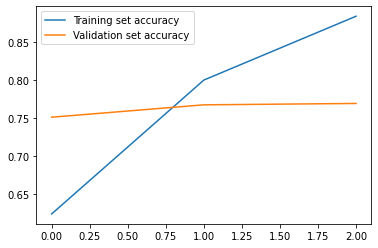

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt



def plot_history(history):
    plt.plot(history.history['sparse_categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_sparse_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()


plot_history(history)

In [ ]:
model.evaluate(val_X,val_y)

70/70 [==============================] - 14s 194ms/step - loss: 0.8544 - sparse_categorical_accuracy: 0.7697


[0.854388415813446, 0.7696832418441772]